In [121]:
# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style


# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import time
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.preprocessing import StandardScaler


In [122]:
df = pd.read_csv('Fish_results_clean.csv')
df.head()

,Age,Conc_tricaine,Recovery,Not_SM_or_TR,Length
0,21,0.014,1,1,7.0
1,21,0.014,1,1,7.0
2,21,0.015,1,1,7.0
3,21,0.015,1,1,7.0
4,21,0.015,1,1,7.0


In [123]:
#My target column is recovery
target_column = 'Recovery'
df[target_column].value_counts()

1    1356
0     363
Name: Recovery, dtype: int64

In [124]:
#Split into numerical and binary columns
df['Not_SM_or_TR']=df['Not_SM_or_TR'].astype('str')


numerical_columns_selector = selector(dtype_include=["int", "float"])
numerical_columns = numerical_columns_selector(df)
numerical_columns
data_numeric = df[numerical_columns]
binary_columns = ['Not_SM_or_TR']
all_columns = numerical_columns + binary_columns + [
    target_column]

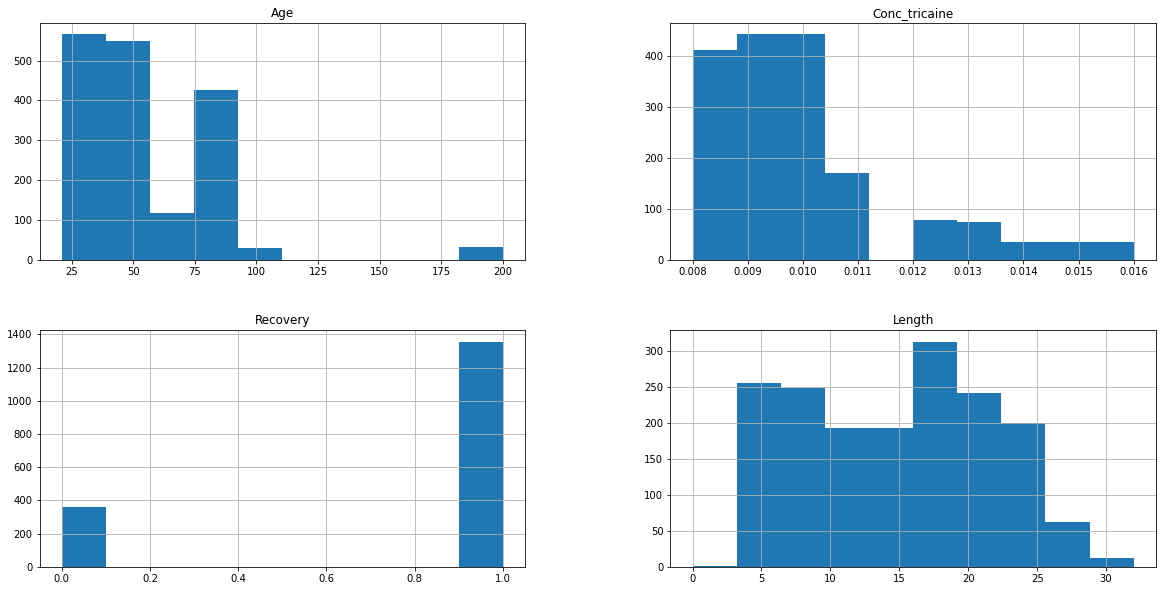

In [125]:
#Try to visualise the data set
_ = df.hist(figsize=(20, 10))

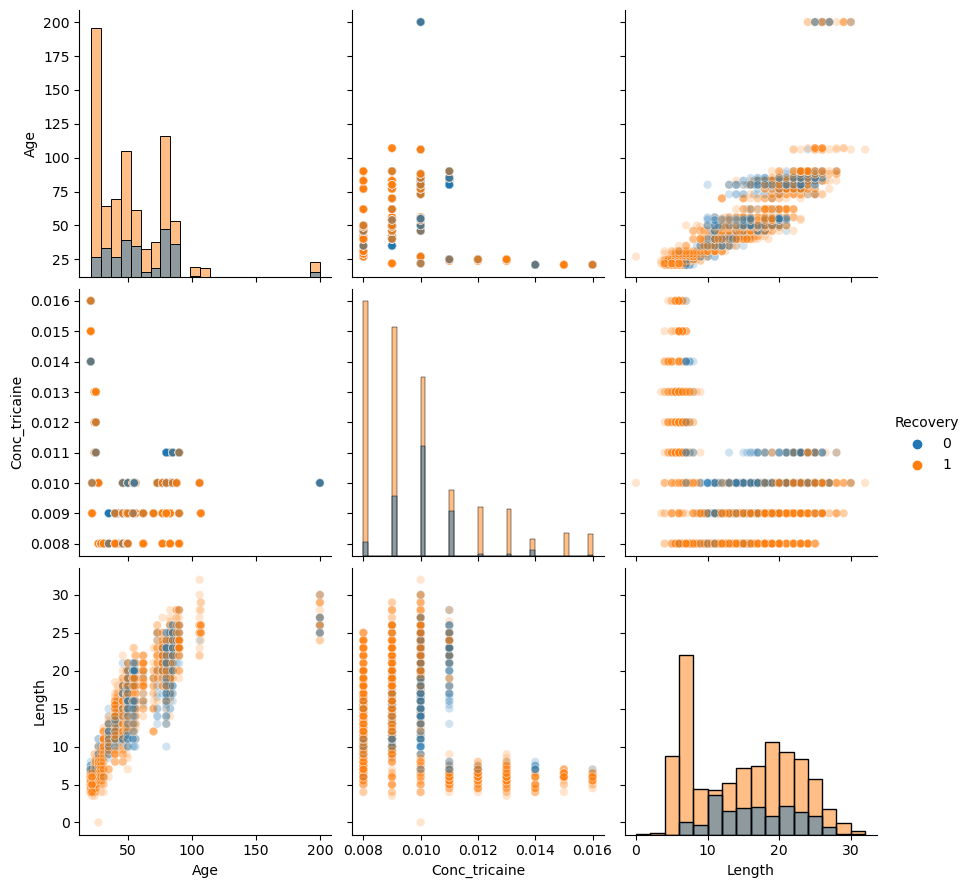

In [126]:
#Nice way to visualise the data

n_samples_to_plot = 5000
columns = ['Age', 'Conc_tricaine', 'Length']

plt.rcdefaults()

import seaborn as sns
_ = sns.pairplot(data=df[:n_samples_to_plot], vars=columns,
                 hue=target_column, plot_kws={'alpha': 0.2},
                 height=3, diag_kind='hist')

In [127]:
target_name = "Recovery"
target = df[target_name].to_numpy()
target

data_numeric = data_numeric.drop(columns=[target_name])


data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target,random_state=42)

print(
    f"The training dataset contains {data_train.shape[0]} samples and "
    f"{data_train.shape[1]} features")
print(
    f"The testing dataset contains {data_test.shape[0]} samples and "
    f"{data_test.shape[1]} features")

The training dataset contains 1289 samples and 3 features
The testing dataset contains 430 samples and 3 features


In [128]:
#Use Logistic Regression with numerical input

model = LogisticRegression(solver='lbfgs')
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

print(f"The model {model.__class__.__name__} was trained in "
      f"{elapsed_time:.3f} seconds for {model.n_iter_} iterations")

The model LogisticRegression was trained in 0.013 seconds for [27] iterations


In [129]:
target_predicted = model.predict(data_test)
target_predicted[:5] 
#Predicted Recovery or no recovery

print(f"The test accuracy using a {model.__class__.__name__} is "
      f"{model.score(data_test, target_test):.3f}")

The test accuracy using a LogisticRegression is 0.779


In [130]:
#Check the accuracy against just assigning all non recovery, or all recovery.

#Split set into training and testing
data_numeric_train, data_numeric_test, target_train, target_test = \
    train_test_split(data_numeric, target, random_state=0)

always_recovery = DummyClassifier(strategy="constant",
                                   constant=1)
always_recovery.fit(data_numeric_train, target_train)
score = always_recovery.score(data_numeric_test, target_test)
print(f"The test accuracy using an 'always recovery model' is "
      f"{always_recovery.score(data_test, target_test):.3f}")

always_non_recovery = DummyClassifier(strategy="constant",
                                   constant=0)
always_non_recovery.fit(data_numeric_train, target_train)
score = always_non_recovery.score(data_numeric_test, target_test)
print(f"The test accuracy using an 'always non recovery model' is "
      f"{always_non_recovery.score(data_test, target_test):.3f}")

#The test accuracy of the Logistic Model is not very good when we compare it to just assiging all recovery or all non-recovery.

The test accuracy using an 'always recovery model' is 0.781
The test accuracy using an 'always non recovery model' is 0.219


In [131]:
#Can also scale the numerical values to make it more accurate
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='lbfgs'))
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model[-1].n_iter_} iterations")

The accuracy using a Pipeline is 0.781 with a fitting time of 0.016 seconds in [11] iterations


In [132]:
scores = cross_val_score(model, data_numeric, target, cv=5)
scores
print(f"The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.628 +/- 0.223


In [133]:
#Now lets include the binary column which is processed using the Ordinal Encoder
binary_encoding_columns = ['Not_SM_or_TR']
scaling_columns=['Age', 'Conc_tricaine', 'Length']

preprocessor = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns),
    ('standard-scaler', StandardScaler(), scaling_columns)])

In [134]:
model = make_pipeline(
    preprocessor, LogisticRegression(solver='lbfgs', max_iter=1000))
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)
data_test.head()
_ = model.fit(data_train, target_train)
scores = cross_val_score(model, data, target, cv=5)
print(f"The accuracy is: {scores.mean():.3f} +- {scores.std():.3f}")

#This model also is not great lets use a more powerful model.

The accuracy is: 0.601 +- 0.238


In [144]:
preprocessor = ColumnTransformer([
    ('binary-encoder', OrdinalEncoder(), binary_encoding_columns)])
model = make_pipeline(preprocessor, HistGradientBoostingClassifier())
_ = model.fit(data_train, target_train)
model.score(data_test, target_test)

0.7790697674418605